# AIN 214 - PA4 - 2023
## Building kNN and Logistic Regression Classifiers


# THE STUDENT INFO
## Student Name:Arda Deniz Ayyıldız
## Student ID:2210765018

# Dataset: We will use the Breast Cancer Wisconsin (Diagnostic) Dataset available on Kaggle for the assignment. 
https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data

## 1. Data Preprocessing

In this section, you will:
- Import necessary libraries
- Load the dataset
- Handle missing values and outliers
- Convert non-numeric values to numeric 
- Perform data normalization

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import  cross_validate
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from pandas.core.common import SettingWithCopyWarning
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=ConvergenceWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

Customer=pd.read_csv(r"data.csv")

In [7]:
df=Customer.copy()

In [8]:
def check_df(dataframe, head=5):
    print(f"##################### Shape #####################\n")
    print(dataframe.shape)

    print(f"\n##################### Types #####################\n")
    print(dataframe.dtypes)

    print(f"\n##################### Head #####################\n")
    print(dataframe.head(head))

    print(f"\n##################### Tail #####################\n")
    print(dataframe.tail(head))

    print(f"\n##################### NA #####################\n")
    print(dataframe.isnull().sum())
    
    print(f"\n##################### Total_NA #####################\n")
    print(dataframe.isnull().sum().sum())

    print(f"\n##################### Quantiles #####################\n")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [9]:
check_df(df)

##################### Shape #####################

(569, 33)

##################### Types #####################

id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
                            ...   
concavity_worst            float64
concave points_worst       float64
symmetry_worst             float64
fractal_dimension_worst    float64
Unnamed: 32                float64
Length: 33, dtype: object

##################### Head #####################

         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
0    842302         M       17.990        10.380         122.800   1001.000            0.118             0.278           0.300                0.147          0.242   
1    842517         M       20.570        17.770         132.900   1326.000            0.085 

In [10]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    It gives the names of categorical, numerical and categorical but cardinal variables in the data set.
     Note: Categorical variables with numerical appearance are also included in categorical variables.

    Parameters
    ------
        dataframe: dataframe
                The dataframe from which variable names are to be retrieved
        cat_th: int, optional
                Class threshold for numeric but categorical variables
        car_th: int, optinal
                Class threshold for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical Variables List
        num_cols: list
                Numeric Variables List
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = Total Number of Variables
        cat_cols includes num_but_cat
        The sum of 3 lists with return is equal to the total number of variables: cat_cols + num_cols + cat_but_car = number of variables

    """


    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [11]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 569
Variables: 33
cat_cols: 2
num_cols: 31
cat_but_car: 0
num_but_cat: 1


In [12]:
cat_cols

['diagnosis', 'Unnamed: 32']

In [13]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

In [14]:
missing_values_table(df)

             n_miss   ratio
Unnamed: 32     569 100.000


In [15]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.990,10.380,122.800,1001.000,0.118,0.278,0.300,0.147,0.242,0.079,1.095,0.905,8.589,153.400,0.006,0.049,0.054,0.016,0.030,0.006,25.380,17.330,184.600,2019.000,0.162,0.666,0.712,0.265,0.460,0.119,NaN
1,842517,M,20.570,17.770,132.900,1326.000,0.085,0.079,0.087,0.070,0.181,0.057,0.543,0.734,3.398,74.080,0.005,0.013,0.019,0.013,0.014,0.004,24.990,23.410,158.800,1956.000,0.124,0.187,0.242,0.186,0.275,0.089,NaN
2,84300903,M,19.690,21.250,130.000,1203.000,0.110,0.160,0.197,0.128,0.207,0.060,0.746,0.787,4.585,94.030,0.006,0.040,0.038,0.021,0.022,0.005,23.570,25.530,152.500,1709.000,0.144,0.424,0.450,0.243,0.361,0.088,NaN
3,84348301,M,11.420,20.380,77.580,386.100,0.142,0.284,0.241,0.105,0.260,0.097,0.496,1.156,3.445,27.230,0.009,0.075,0.057,0.019,0.060,0.009,14.910,26.500,98.870,567.700,0.210,0.866,0.687,0.258,0.664,0.173,NaN
4,84358402,M,20.290,14.340,135.100,1297.000,0.100,0.133,0.198,0.104,0.181,0.059,0.757,0.781,5.438,94.440,0.011,0.025,0.057,0.019,0.018,0.005,22.540,16.670,152.200,1575.000,0.137,0.205,0.400,0.163,0.236,0.077,NaN


In [16]:
df.drop('Unnamed: 32', axis=1, inplace=True)
df.drop('id', axis=1, inplace=True)

In [17]:
missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


In [18]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 569
Variables: 31
cat_cols: 1
num_cols: 30
cat_but_car: 0
num_but_cat: 0


In [19]:
diagnosis_mapping = {'M': 1, 'B': 0}
df['diagnosis'] = df['diagnosis'].map(diagnosis_mapping)

In [20]:
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.990,10.380,122.800,1001.000,0.118,0.278,0.300,0.147,0.242,0.079,1.095,0.905,8.589,153.400,0.006,0.049,0.054,0.016,0.030,0.006,25.380,17.330,184.600,2019.000,0.162,0.666,0.712,0.265,0.460,0.119
1,1,20.570,17.770,132.900,1326.000,0.085,0.079,0.087,0.070,0.181,0.057,0.543,0.734,3.398,74.080,0.005,0.013,0.019,0.013,0.014,0.004,24.990,23.410,158.800,1956.000,0.124,0.187,0.242,0.186,0.275,0.089
2,1,19.690,21.250,130.000,1203.000,0.110,0.160,0.197,0.128,0.207,0.060,0.746,0.787,4.585,94.030,0.006,0.040,0.038,0.021,0.022,0.005,23.570,25.530,152.500,1709.000,0.144,0.424,0.450,0.243,0.361,0.088
3,1,11.420,20.380,77.580,386.100,0.142,0.284,0.241,0.105,0.260,0.097,0.496,1.156,3.445,27.230,0.009,0.075,0.057,0.019,0.060,0.009,14.910,26.500,98.870,567.700,0.210,0.866,0.687,0.258,0.664,0.173
4,1,20.290,14.340,135.100,1297.000,0.100,0.133,0.198,0.104,0.181,0.059,0.757,0.781,5.438,94.440,0.011,0.025,0.057,0.019,0.018,0.005,22.540,16.670,152.200,1575.000,0.137,0.205,0.400,0.163,0.236,0.077


In [21]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [22]:
for col in num_cols:
    print(col,"--->",check_outlier(df,col))

radius_mean ---> True
texture_mean ---> True
perimeter_mean ---> True
area_mean ---> True
smoothness_mean ---> True
compactness_mean ---> True
concavity_mean ---> True
concave points_mean ---> True
symmetry_mean ---> True
fractal_dimension_mean ---> True
radius_se ---> True
texture_se ---> True
perimeter_se ---> True
area_se ---> True
smoothness_se ---> True
compactness_se ---> True
concavity_se ---> True
concave points_se ---> True
symmetry_se ---> True
fractal_dimension_se ---> True
radius_worst ---> True
texture_worst ---> True
perimeter_worst ---> True
area_worst ---> True
smoothness_worst ---> True
compactness_worst ---> True
concavity_worst ---> True
concave points_worst ---> False
symmetry_worst ---> True
fractal_dimension_worst ---> True


In [23]:
for col in num_cols:
    replace_with_thresholds(df,col)

In [24]:
for col in num_cols:
    print(col,"--->",check_outlier(df,col))

radius_mean ---> False
texture_mean ---> False
perimeter_mean ---> False
area_mean ---> False
smoothness_mean ---> False
compactness_mean ---> False
concavity_mean ---> False
concave points_mean ---> False
symmetry_mean ---> False
fractal_dimension_mean ---> False
radius_se ---> False
texture_se ---> False
perimeter_se ---> False
area_se ---> False
smoothness_se ---> False
compactness_se ---> False
concavity_se ---> False
concave points_se ---> False
symmetry_se ---> False
fractal_dimension_se ---> False
radius_worst ---> False
texture_worst ---> False
perimeter_worst ---> False
area_worst ---> False
smoothness_worst ---> False
compactness_worst ---> False
concavity_worst ---> False
concave points_worst ---> False
symmetry_worst ---> False
fractal_dimension_worst ---> False


In [25]:
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.990,10.380,122.800,1001.000,0.118,0.229,0.282,0.147,0.242,0.079,0.849,0.905,5.984,86.200,0.006,0.049,0.054,0.016,0.030,0.006,25.380,17.330,184.600,1937.050,0.162,0.627,0.712,0.265,0.419,0.119
1,1,20.570,17.770,132.900,1326.000,0.085,0.079,0.087,0.070,0.181,0.057,0.543,0.734,3.398,74.080,0.005,0.013,0.019,0.013,0.014,0.004,24.990,23.410,158.800,1937.050,0.124,0.187,0.242,0.186,0.275,0.089
2,1,19.690,21.250,130.000,1203.000,0.110,0.160,0.197,0.128,0.207,0.060,0.746,0.787,4.585,86.200,0.006,0.040,0.038,0.021,0.022,0.005,23.570,25.530,152.500,1709.000,0.144,0.424,0.450,0.243,0.361,0.088
3,1,11.420,20.380,77.580,386.100,0.134,0.229,0.241,0.105,0.246,0.079,0.496,1.156,3.445,27.230,0.009,0.062,0.057,0.019,0.036,0.008,14.910,26.500,98.870,567.700,0.190,0.627,0.687,0.258,0.419,0.123
4,1,20.290,14.340,135.100,1297.000,0.100,0.133,0.198,0.104,0.181,0.059,0.757,0.781,5.438,86.200,0.011,0.025,0.057,0.019,0.018,0.005,22.540,16.670,152.200,1575.000,0.137,0.205,0.400,0.163,0.236,0.077


In [26]:
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df)

normalized_df = pd.DataFrame(normalized_data, columns=df.columns)

In [27]:
normalized_df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1.000,0.738,0.033,0.762,0.725,0.798,1.000,1.000,0.952,0.967,0.999,1.000,0.263,1.000,1.000,0.430,0.790,0.651,0.627,0.789,0.743,0.893,0.173,0.980,1.000,0.763,1.000,0.906,0.912,1.000,0.940
1,1.000,0.911,0.393,0.859,1.000,0.353,0.283,0.308,0.454,0.518,0.233,0.586,0.180,0.505,0.847,0.322,0.183,0.225,0.529,0.214,0.370,0.874,0.371,0.792,1.000,0.436,0.266,0.308,0.639,0.451,0.500
2,1.000,0.852,0.562,0.831,0.896,0.682,0.672,0.699,0.828,0.708,0.348,0.860,0.206,0.732,1.000,0.407,0.638,0.465,0.813,0.521,0.516,0.801,0.441,0.746,0.870,0.611,0.662,0.573,0.835,0.780,0.479
3,1.000,0.298,0.520,0.326,0.205,1.000,1.000,0.855,0.681,1.000,1.000,0.521,0.384,0.514,0.257,0.679,1.000,0.686,0.737,1.000,1.000,0.357,0.472,0.354,0.218,1.000,1.000,0.874,0.885,1.000,1.000
4,1.000,0.892,0.225,0.880,0.975,0.559,0.542,0.701,0.675,0.516,0.308,0.876,0.203,0.896,1.000,0.897,0.377,0.690,0.745,0.345,0.592,0.748,0.152,0.743,0.793,0.552,0.296,0.509,0.558,0.304,0.320


## 2. Data Visualization

Visualize the data to understand it better:
- Correlation heatmap
- Distribution plots for at least 3 features


In [28]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.90):
    corr_matrix = dataframe.corr().abs()
    drop_list = corr_matrix.columns[corr_matrix.max() > corr_th].tolist()
    
    if plot:
        cmap = sns.diverging_palette(220, 10, as_cmap=True)
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, cmap=cmap, annot=False, fmt=".2f", annot_kws={"size": 10})
        plt.show()
        
    

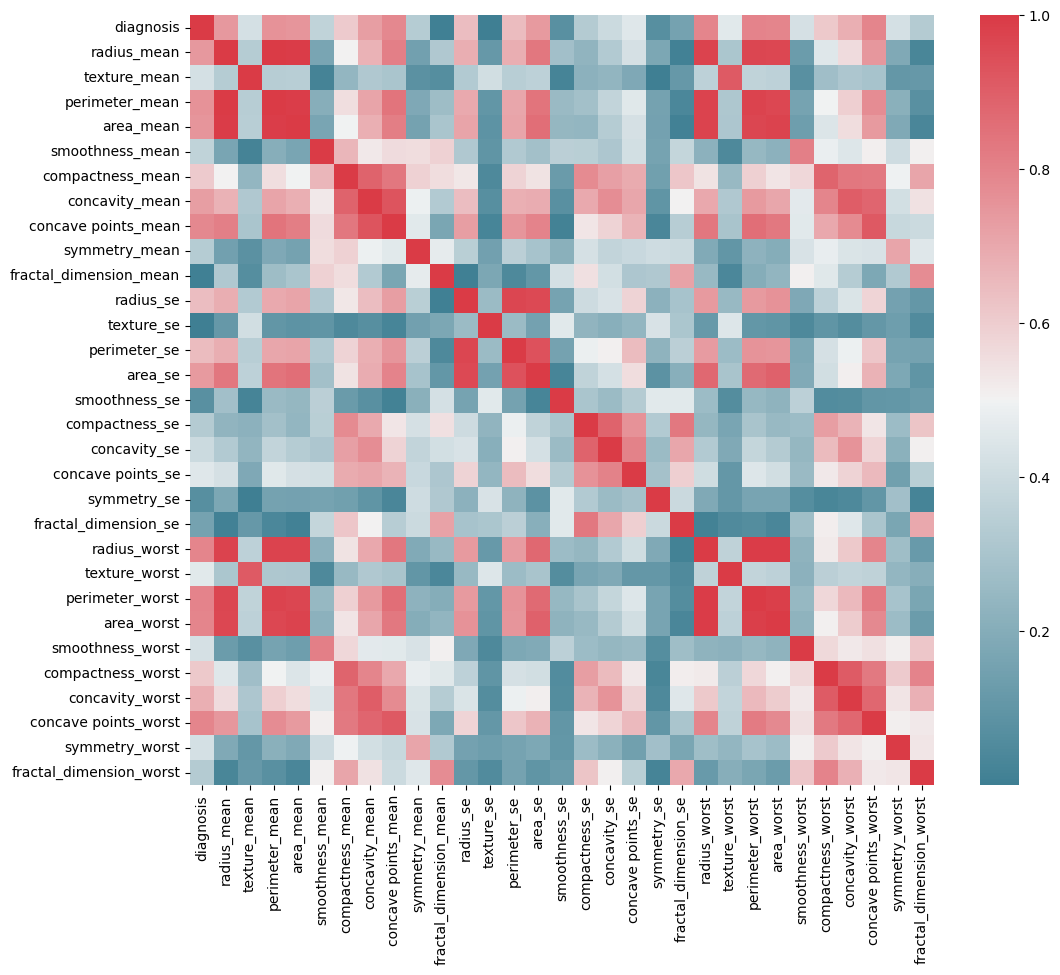

In [29]:
high_correlated_cols(df,True)

In [30]:
def num_summary(dataframe, numerical_col, plot=False):

    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print("------",numerical_col,"------")
    print(dataframe[numerical_col].describe(quantiles).T)
    

    if plot:
        print(f"\n##### Plot #####\n")
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()
    print("###################################################\n")  

------ radius_mean ------
count   569.000
mean     14.063
std       3.340
min       6.981
5%        9.529
10%      10.260
20%      11.366
30%      12.012
40%      12.726
50%      13.370
60%      14.058
70%      15.056
80%      17.068
90%      19.530
95%      20.576
99%      21.900
max      21.900
Name: radius_mean, dtype: float64

##### Plot #####



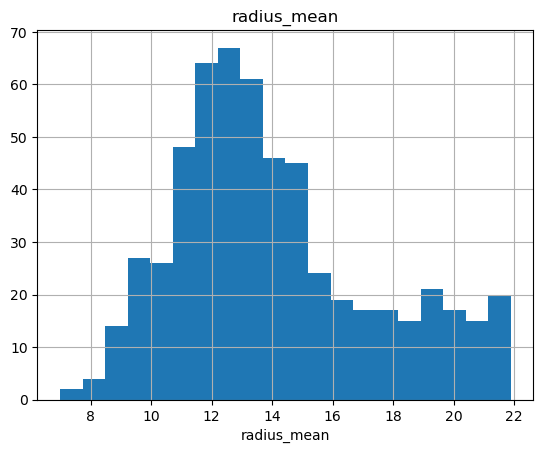

###################################################

------ texture_mean ------
count   569.000
mean     19.255
std       4.188
min       9.710
5%       13.088
10%      14.078
20%      15.656
30%      16.840
40%      17.912
50%      18.840
60%      19.968
70%      21.272
80%      22.440
90%      24.992
95%      27.150
99%      30.245
max      30.245
Name: texture_mean, dtype: float64

##### Plot #####



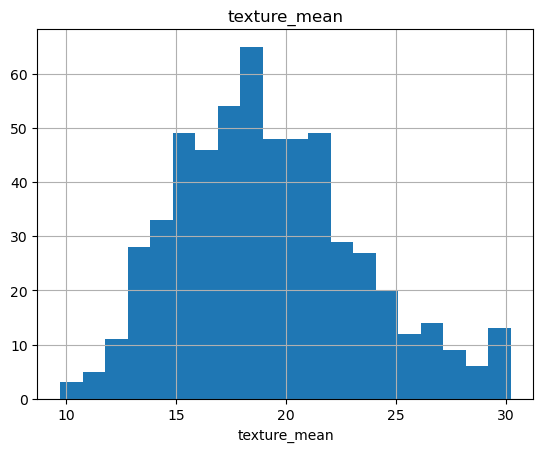

###################################################

------ perimeter_mean ------
count   569.000
mean     91.544
std      23.047
min      43.790
5%       60.496
10%      65.830
20%      73.292
30%      77.360
40%      81.938
50%      86.240
60%      91.420
70%      98.200
80%     111.680
90%     129.100
95%     135.820
99%     147.495
max     147.495
Name: perimeter_mean, dtype: float64

##### Plot #####



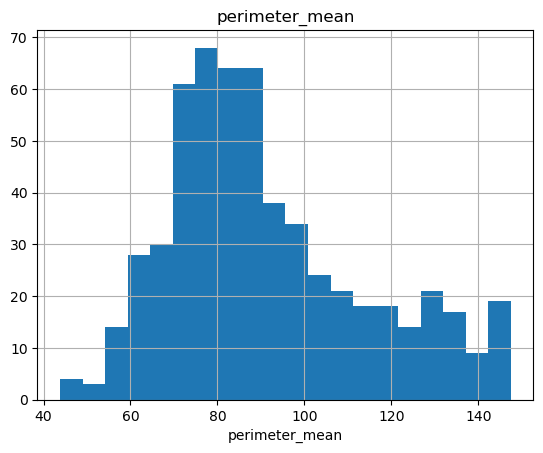

###################################################

------ area_mean ------
count    569.000
mean     639.765
std      305.344
min      143.500
5%       275.780
10%      321.600
20%      396.560
30%      444.060
40%      496.440
50%      551.100
60%      609.740
70%      700.660
80%      915.060
90%     1177.400
95%     1309.800
99%     1326.300
max     1326.300
Name: area_mean, dtype: float64

##### Plot #####



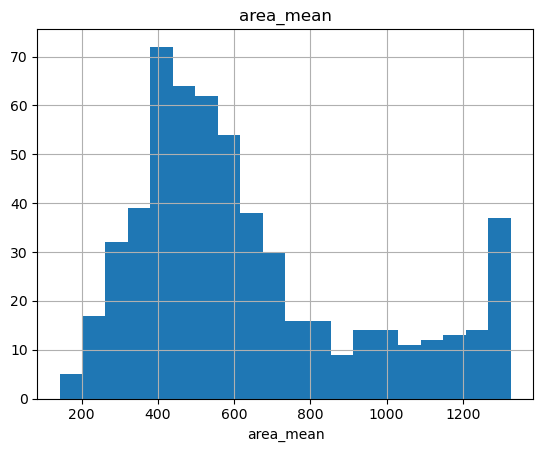

###################################################

------ smoothness_mean ------
count   569.000
mean      0.096
std       0.014
min       0.058
5%        0.075
10%       0.080
20%       0.084
30%       0.088
40%       0.092
50%       0.096
60%       0.099
70%       0.103
80%       0.107
90%       0.115
95%       0.119
99%       0.133
max       0.134
Name: smoothness_mean, dtype: float64

##### Plot #####



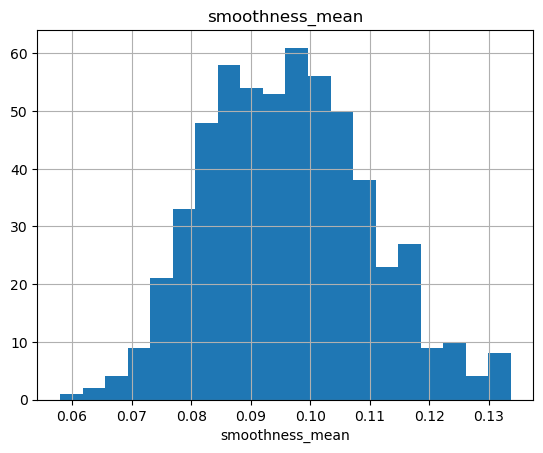

###################################################

------ compactness_mean ------
count   569.000
mean      0.103
std       0.049
min       0.019
5%        0.041
10%       0.050
20%       0.060
30%       0.070
40%       0.080
50%       0.093
60%       0.109
70%       0.122
80%       0.142
90%       0.175
95%       0.209
99%       0.229
max       0.229
Name: compactness_mean, dtype: float64

##### Plot #####



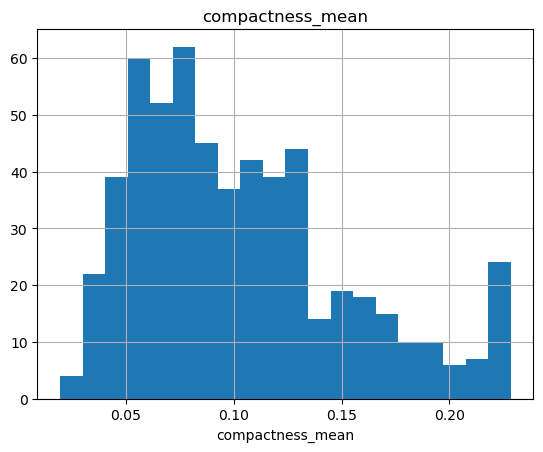

###################################################

------ concavity_mean ------
count   569.000
mean      0.087
std       0.074
min       0.000
5%        0.005
10%       0.014
20%       0.025
30%       0.034
40%       0.045
50%       0.062
60%       0.086
70%       0.112
80%       0.150
90%       0.203
95%       0.243
99%       0.282
max       0.282
Name: concavity_mean, dtype: float64

##### Plot #####



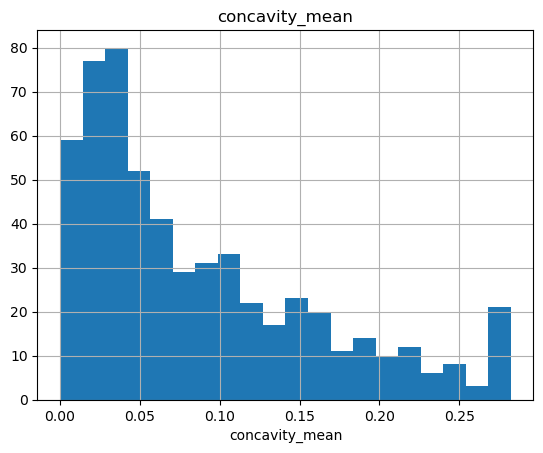

###################################################



In [31]:
counter=0
for col in num_cols:
    if counter>6:
        break
    num_summary(df,col,True)
    counter+=1

## 3. Data Splitting

Manually split the data into training and testing sets in a 70:30 ratio:
- Shuffle and split the data
- Avoid using predefined functions like train_test_split for this task


In [32]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

split_ratio = 0.7
split_index = int(split_ratio * len(df))

y_train = df.loc[:split_index - 1, 'diagnosis']
X_train = df.loc[:split_index - 1, df.columns != 'diagnosis']

y_test = df.loc[split_index:, 'diagnosis']
X_test = df.loc[split_index:, df.columns != 'diagnosis']

In [33]:
X_train

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,12.470,18.600,81.090,481.900,0.100,0.106,0.080,0.038,0.193,0.064,0.396,1.044,2.497,30.290,0.007,0.019,0.027,0.010,0.018,0.004,14.970,24.640,96.050,677.900,0.143,0.238,0.267,0.102,0.301,0.087
1,18.940,21.310,123.600,1130.000,0.090,0.103,0.108,0.080,0.158,0.055,0.789,0.797,5.486,86.200,0.004,0.017,0.023,0.014,0.014,0.002,24.860,26.580,165.900,1866.000,0.119,0.234,0.269,0.179,0.255,0.066
2,15.460,19.480,101.700,748.900,0.109,0.122,0.147,0.081,0.193,0.058,0.474,0.786,3.094,48.310,0.006,0.015,0.028,0.011,0.014,0.002,19.260,26.000,124.900,1156.000,0.155,0.239,0.379,0.151,0.284,0.080
3,12.400,17.680,81.470,467.800,0.105,0.132,0.077,0.028,0.181,0.071,0.177,1.460,2.204,15.430,0.010,0.033,0.049,0.012,0.022,0.006,12.880,22.910,89.610,515.800,0.145,0.263,0.240,0.074,0.256,0.094
4,11.540,14.440,74.650,402.900,0.100,0.112,0.067,0.026,0.182,0.068,0.278,1.768,1.628,20.860,0.012,0.041,0.056,0.015,0.018,0.006,12.260,19.680,78.780,457.800,0.135,0.212,0.180,0.069,0.233,0.081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,11.630,29.290,74.870,415.100,0.094,0.086,0.072,0.020,0.180,0.062,0.314,2.426,2.150,23.130,0.010,0.024,0.043,0.009,0.025,0.002,13.120,38.810,86.040,527.800,0.141,0.203,0.292,0.068,0.288,0.072
394,17.910,21.020,124.400,994.000,0.123,0.229,0.282,0.120,0.211,0.071,0.403,0.775,3.123,41.510,0.007,0.037,0.062,0.011,0.016,0.005,20.800,27.780,149.600,1304.000,0.187,0.592,0.786,0.196,0.325,0.120
395,15.710,13.930,102.000,761.700,0.095,0.095,0.071,0.059,0.182,0.057,0.312,0.816,1.972,27.940,0.005,0.015,0.017,0.013,0.017,0.002,17.500,19.250,114.300,922.800,0.122,0.195,0.171,0.137,0.272,0.071
396,14.800,17.660,95.880,674.800,0.092,0.089,0.041,0.023,0.189,0.059,0.220,0.622,1.482,19.750,0.005,0.012,0.018,0.007,0.023,0.002,16.430,22.740,105.900,829.500,0.123,0.188,0.206,0.083,0.360,0.073


In [34]:
y_train

0      0
1      1
2      1
3      0
4      0
      ..
393    0
394    1
395    0
396    0
397    1
Name: diagnosis, Length: 398, dtype: int64

In [35]:
X_test

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
398,14.970,16.950,96.220,685.900,0.099,0.079,0.026,0.038,0.178,0.057,0.271,1.217,1.893,24.280,0.005,0.014,0.007,0.009,0.013,0.002,16.110,23.000,104.600,793.700,0.122,0.164,0.066,0.085,0.240,0.064
399,14.780,23.940,97.400,668.300,0.117,0.148,0.127,0.090,0.195,0.067,0.358,1.281,2.450,35.240,0.007,0.023,0.023,0.012,0.019,0.003,17.310,33.390,114.600,925.100,0.165,0.342,0.302,0.161,0.332,0.089
400,16.240,18.770,108.800,805.100,0.107,0.180,0.195,0.091,0.188,0.067,0.287,0.917,2.464,28.090,0.005,0.035,0.039,0.012,0.014,0.004,18.550,25.090,126.900,1031.000,0.137,0.471,0.503,0.173,0.277,0.106
401,18.460,18.520,121.100,1075.000,0.099,0.105,0.134,0.088,0.213,0.060,0.700,1.475,4.782,80.600,0.006,0.016,0.028,0.014,0.024,0.004,22.930,27.680,152.200,1603.000,0.140,0.209,0.316,0.164,0.369,0.086
402,11.300,18.190,73.930,389.400,0.096,0.133,0.155,0.029,0.205,0.077,0.243,1.642,2.369,16.390,0.007,0.059,0.082,0.013,0.020,0.008,12.580,27.960,87.160,472.900,0.135,0.485,0.744,0.122,0.331,0.123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,8.888,14.640,58.790,244.000,0.098,0.153,0.086,0.029,0.190,0.079,0.526,0.852,3.168,25.440,0.013,0.062,0.057,0.018,0.025,0.008,9.733,15.670,62.560,284.400,0.121,0.244,0.143,0.048,0.225,0.108
565,11.640,18.330,75.170,412.500,0.114,0.102,0.071,0.035,0.180,0.065,0.306,1.657,2.155,20.620,0.009,0.023,0.029,0.014,0.016,0.004,13.140,29.260,85.510,521.700,0.169,0.266,0.287,0.122,0.281,0.091
566,14.290,16.820,90.300,632.600,0.064,0.027,0.007,0.006,0.151,0.054,0.130,0.720,0.844,10.770,0.003,0.004,0.005,0.004,0.015,0.001,14.910,20.650,94.440,684.600,0.086,0.050,0.039,0.033,0.246,0.061
567,13.980,19.620,91.120,599.500,0.106,0.113,0.113,0.065,0.167,0.065,0.221,0.953,1.602,18.850,0.005,0.018,0.022,0.010,0.012,0.003,17.040,30.800,113.900,869.300,0.161,0.357,0.407,0.183,0.318,0.105


In [36]:
y_test

398    0
399    1
400    1
401    1
402    0
      ..
564    0
565    0
566    0
567    1
568    0
Name: diagnosis, Length: 171, dtype: int64

## 4. Model Building

### 4.1. kNN Classifier

- Build and train the kNN model
- Choose the optimal k value using Minkowski distance with at least two different values for p 

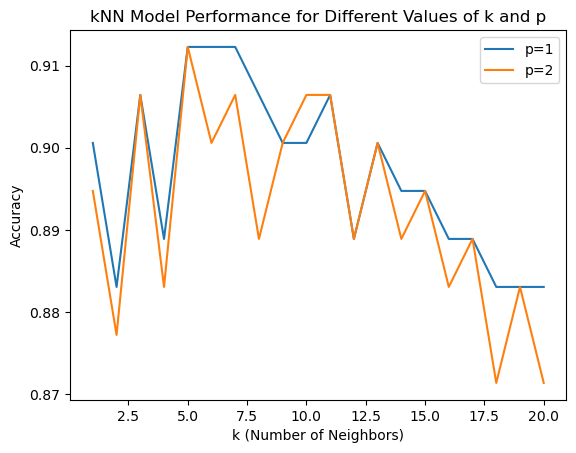

In [37]:
def train_and_evaluate_knn(X_train, y_train, X_test, y_test, k, p):
    
    knn = KNeighborsClassifier(n_neighbors=k, p=p)

    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

k_values = list(range(1, 21))

p_values = [1, 2]

results = {}

for p in p_values:
    accuracies = []

    for k in k_values:
        accuracy = train_and_evaluate_knn(X_train, y_train, X_test, y_test, k, p)
        accuracies.append(accuracy)

    results[p] = accuracies

for p, accuracies in results.items():
    plt.plot(k_values, accuracies, label=f'p={p}')

plt.title('kNN Model Performance for Different Values of k and p')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [38]:
# p=1   and k=5

In [39]:
def train_knn(X_train, y_train, X_test, y_test, k, p):
    knn = KNeighborsClassifier(n_neighbors=k, p=p)

    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)

    return y_pred

In [40]:
k_value = 5  
p_value_knn = 1  
y_pred_knn = train_knn(X_train, y_train, X_test, y_test, k_value, p_value_knn)


### 4.2. Logistic Regression

- Build and train the Logistic Regression model

In [41]:
def train_and_evaluate_logreg(X_train, y_train, X_test):
    logreg = LogisticRegression(random_state=42)

    logreg.fit(X_train, y_train)

    y_pred = logreg.predict(X_test)

    return y_pred

In [42]:
y_pred_logreg = train_and_evaluate_logreg(X_train, y_train, X_test)


## 5. Model Evaluation

### 5.1. Confusion Matrix

Analysis of the confusion matrices for both models:
- Plot and interpret the confusion matrices
- Display accuracy, precision, recall, and F1-score for both models

In [43]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def display_metrics(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f'{model_name} Metrics:')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}\n')

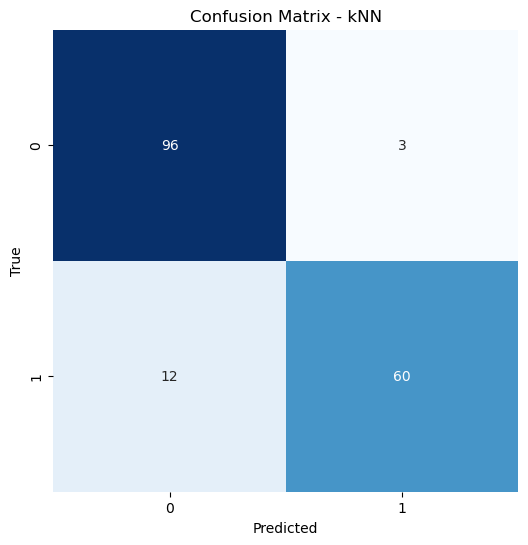

kNN Metrics:
Accuracy: 0.9123
Precision: 0.9524
Recall: 0.8333
F1-score: 0.8889



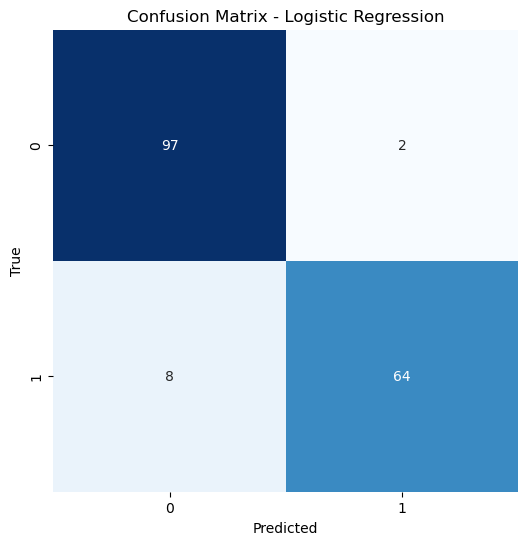

Logistic Regression Metrics:
Accuracy: 0.9415
Precision: 0.9697
Recall: 0.8889
F1-score: 0.9275



In [44]:
plot_confusion_matrix(y_test, y_pred_knn, 'kNN')
display_metrics(y_test, y_pred_knn, 'kNN')

plot_confusion_matrix(y_test, y_pred_logreg, 'Logistic Regression')
display_metrics(y_test, y_pred_logreg, 'Logistic Regression')

### 5.2. Precision-Recall Curves

Evaluate the Precision-Recall curves for both models:
- Plot and analyze the curves

In [45]:
from sklearn.metrics import precision_recall_curve

In [46]:
def plot_precision_recall_curve(y_true, y_scores, model_name):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=model_name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend()
    plt.show()

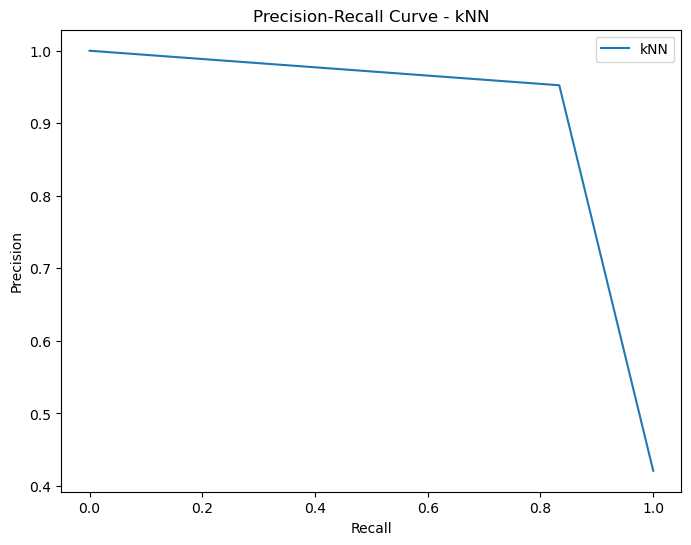

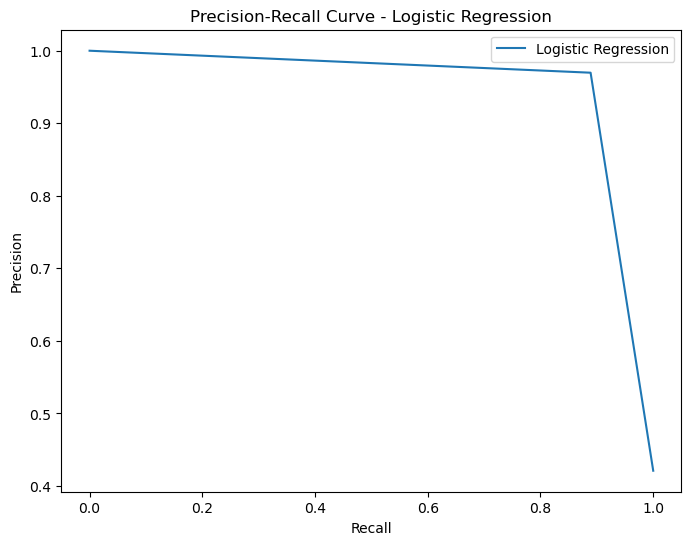

In [47]:
plot_precision_recall_curve(y_test, y_pred_knn, 'kNN')

plot_precision_recall_curve(y_test, y_pred_logreg, 'Logistic Regression')

### 5.3. Choose an appropriate metric to evaulate the models. Compare the models and discuss why you chose the metric.